In [7]:
import fastdm
import pickle as pkl
import subprocess
import pandas

import seaborn as sns

## Load data

In [8]:
behav = pandas.load('/Users/Gilles/Dropbox/Science/tdcs/data/all_data.pandas')
r = pkl.load(open('/Users/Gilles/Dropbox/Science/tdcs/data/fitted_params_fastdm.pkl'))

### Function to get CDF out of fast-dm

In [9]:
def get_cdf(**params):
    
    if 'z' not in params.keys():
        params['z'] = .5
    
    command = ['plot-cdf', '-o', "cdf_tmp.lst"]
    
    translate = {'Z':'szr',
                 'V':'sv',
                 'T':'st0',
                 't':'t0'
                 }
    
    for p in ['a', 'z', 'v', 't', 'd', 'Z', 'V', 'T']:
        key = translate[p] if p in translate.keys() else p
        command += ['-%s' % p, str(params[key])]
        

    p =subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, bufsize=1)
    
    if p.returncode:
        print '***plot-cdf gave error***'
        print streamdata
        raise Exception("Plot-cdf error")
    
    p.wait()
    
    df = pandas.read_csv("cdf_tmp.lst", sep=' ', names=['rt', 'cdf'])
    df.set_index('rt', inplace=True)
    
    
    df['correct'] = df.index > 0
    
    df['censored_cdf'] = df.cdf - df.correct * df.ix[0].cdf


    proportions_correct = df.groupby('correct').censored_cdf.max()

    df['cdf'] = df.apply(lambda row: row.censored_cdf / proportions_correct[row.correct], 1)

    df.ix[~df.correct, 'cdf']  = 1 - df.ix[~df.correct, 'cdf']
    
    return df, proportions_correct.ix[True]

### Function to get condition-specific parameters. This fucntion is specific to my data

In [10]:
def get_parameters(subject_id, acc_spd, stimulation, fastdm_results):
    
    row = fastdm_results.parameters.ix[subject_id]
    
    r = {}
    r['d'] = row.d
    r['z'] = 0.5
    
    for par in ['a', 'v', 't0', 'szr', 'sv', 'st0']:
        r[par] = row['%s_%s_%s' % (par, acc_spd, stimulation)]
        
    return r
    

### Function to get predicted quantiles

In [11]:
def get_quantiles(df, quantiles=(0.1, 0.3, 0.5, 0.7, 0.9)):
    
    result = {}
    
    for correct, d in df.groupby('correct'):
        for i, q in enumerate(quantiles):
            correct_str = 'correct' if correct else 'incorrect'
            result['%d_%s' % (q * 100, correct_str)] = np.abs(np.argmin(np.abs(d.cdf - q)))
            
    return result

In [14]:
get_quantiles(df)

NameError: name 'df' is not defined

## Get parameters for all subjects and conditions

Get all subject codes

In [15]:
behav['ds_subject_code'] = behav.id.map(lambda x: x.split('.')[0])
uq_subject_codes = behav['ds_subject_code'].unique()

# Put all parameters in a list of dictionaries

In [16]:
import itertools

In [17]:
results = []

for sid, acc_spd, stimulation in itertools.product(uq_subject_codes, ['acc', 'spd'], ['anodal', 'sham']):
#    print sid
    pars = get_parameters(sid, acc_spd, stimulation, r)
    df, correct = get_cdf(**pars)
    tmp = {'acc_spd':acc_spd,
         'ds_subject_code':sid,
         'tdcs':stimulation,
         'accuracy':correct}
    tmp.update(get_quantiles(df))
    results.append(tmp)

In [18]:
df_pars = pandas.DataFrame(results)
df_pars = df_pars.merge(on=['ds_subject_code', 'acc_spd', 'tdcs'], right=behav.groupby(['ds_subject_code', 'acc_spd', 'tdcs'], as_index=False).mean(), suffixes=['_predicted', '_data'])

In [19]:
tmp = pandas.melt(df_pars, id_vars=['ds_subject_code', 'acc_spd', 'tdcs'], value_vars=df_pars.columns[:10].tolist())
tmp['percentile'] = tmp.variable.map(lambda x: x.split('_')[0]).astype(int)
tmp['correct'] = tmp.variable.map(lambda x: x.split('_')[1])

In [20]:
accuracy_data_prediction = df_pars.merge(behav.groupby(['ds_subject_code', 'acc_spd', 'tdcs'], as_index=False).accuracy.mean(), on=['ds_subject_code', 'acc_spd', 'tdcs'])

In [21]:
accuracy_data_prediction.head()

,10_correct,10_incorrect,30_correct,30_incorrect,50_correct,50_incorrect,70_correct,70_incorrect,90_correct,90_incorrect,...,accuracy_predicted,ds_subject_code,tdcs,RT,accuracy_data,angle,coherence,left_right,trial_NR,accuracy
0,0.39,0.37,0.43,0.40,0.45,0.43,0.48,0.46,0.54,0.52,...,0.996885,S1,anodal,461.837288,1.000000,180,0.4171,1.494915,290.972881,1.000000
1,0.47,0.45,0.51,0.49,0.54,0.52,0.58,0.57,0.66,0.65,...,0.996426,S1,sham,563.682432,0.986486,180,0.4171,1.516892,308.006757,0.986486
2,0.37,0.35,0.40,0.38,0.43,0.41,0.46,0.44,0.52,0.49,...,0.998019,S1,anodal,443.265574,0.996721,180,0.4171,1.504918,309.714754,0.996721
3,0.45,0.43,0.49,0.48,0.52,0.51,0.56,0.54,0.64,0.62,...,0.991249,S1,sham,541.039474,0.983553,180,0.4171,1.483553,293.190789,0.983553
4,0.52,0.52,0.66,0.66,0.77,0.77,0.90,0.90,1.18,1.17,...,0.681536,S10,anodal,802.472843,0.674121,180,0.2764,1.507987,311.498403,0.674121


acc
acc
spd
spd


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


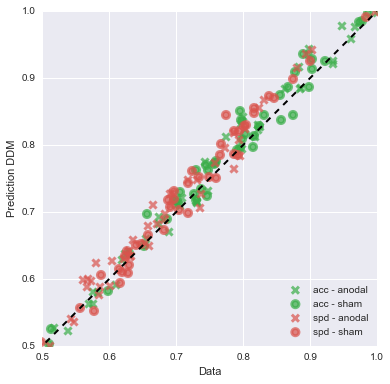

In [22]:
fig = plt.figure(figsize=(6,6))

color_dict = {'acc':sns.xkcd_rgb["medium green"],
              'spd':sns.xkcd_rgb["pale red"]}

tdcs_dict = {'sham':'o',
             'anodal':'x'}


for (acc_spd, tdcs), d in accuracy_data_prediction.groupby(['acc_spd', 'tdcs']):
    print acc_spd
    plt.scatter(d.accuracy_data, d.accuracy_predicted,
                s=50,
                color=color_dict[acc_spd],
                marker=tdcs_dict[tdcs],
                label='%s - %s' % (acc_spd, tdcs),
                linewidths=(3,),
                alpha=0.7)

    
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.plot([0, 1], [0, 1], c='k', lw=2, ls='--')
plt.legend(loc='lower right')
plt.xlabel('Data')
plt.ylabel('Prediction DDM')

## Get quantiles of behavioral data

In [23]:
behav['rt'] = behav.RT / 1000.
behav_quantiles = behav.groupby(['ds_subject_code', 'acc_spd', 'tdcs', 'accuracy']).rt.quantile((0.1, 0.3, 0.5, 0.7, 0.9)).reset_index()
behav_quantiles.rename(columns={'level_4':'percentile', 0:'value', 'accuracy':'correct'}, inplace=True)
behav_quantiles['percentile'] *= 100
behav_quantiles['correct'] = behav_quantiles['correct'].map({False:'incorrect', True:'correct'})

## Merge with model predictions

In [24]:
data_predicted = pandas.merge(behav_quantiles, tmp, on=['acc_spd', 'percentile', 'ds_subject_code', 'correct', 'tdcs'], suffixes=['_data', '_predicted'])
data_predicted.head()

,ds_subject_code,acc_spd,tdcs,correct,percentile,value_data,variable,value_predicted
0,A10,acc,anodal,incorrect,10,0.316,10_incorrect,0.32
1,A10,acc,anodal,incorrect,30,0.383,30_incorrect,0.43
2,A10,acc,anodal,incorrect,50,0.483,50_incorrect,0.51
3,A10,acc,anodal,incorrect,70,0.617,70_incorrect,0.62
4,A10,acc,anodal,incorrect,90,0.918,90_incorrect,0.86


## Plot

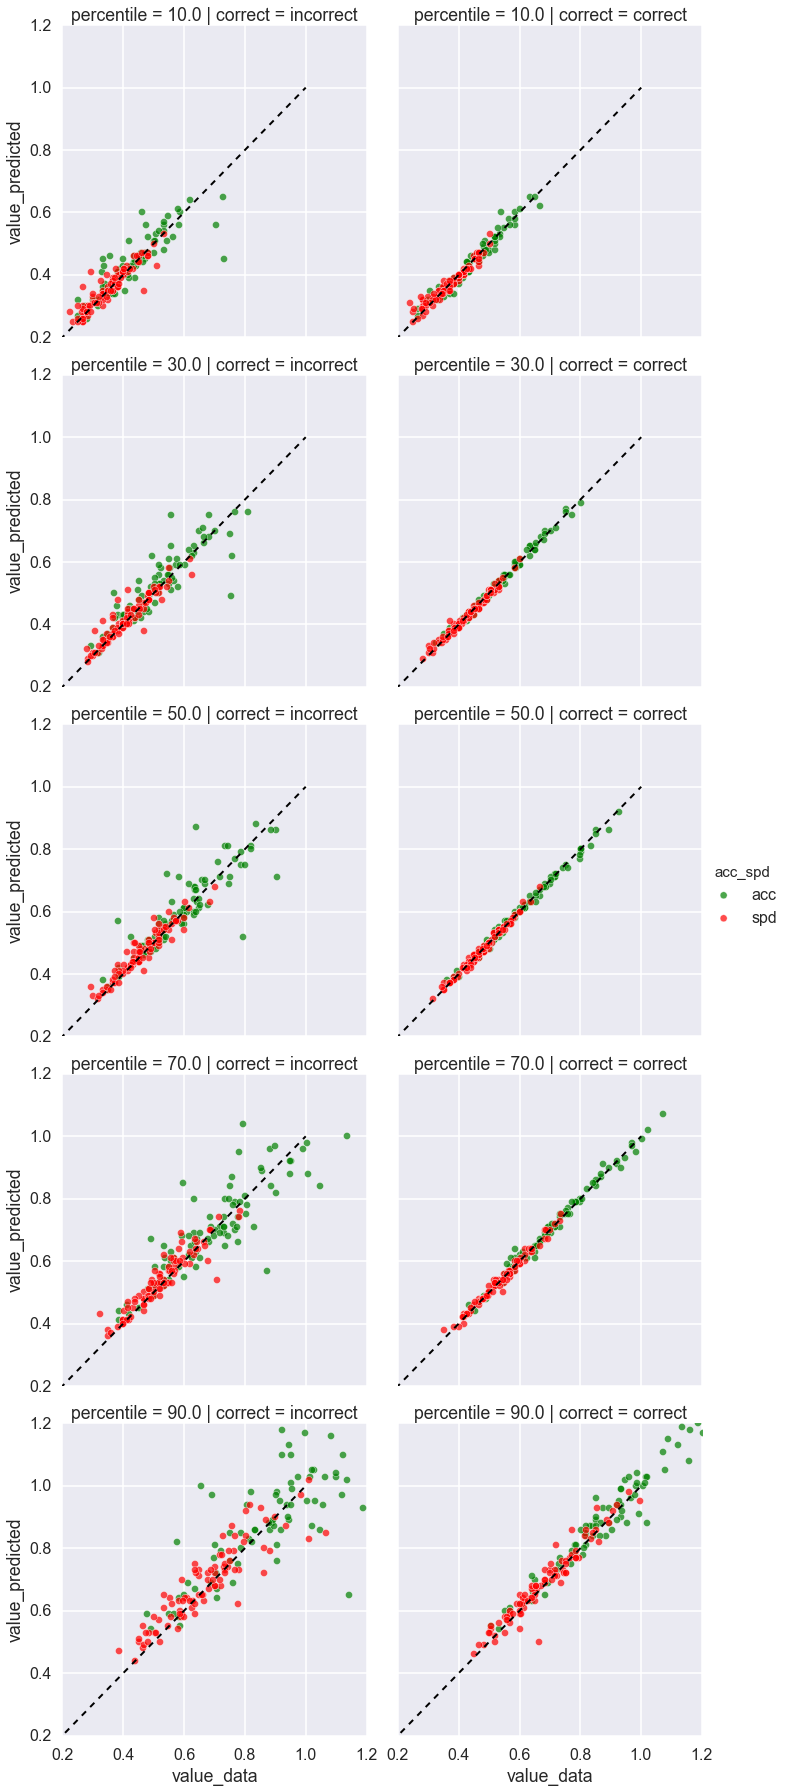

In [25]:
sns.set_context('poster')
g = sns.FacetGrid(data_predicted, hue="acc_spd", palette=['green', 'red'], row='percentile', col='correct', size=5)
e = g.map(plt.scatter, "value_data", "value_predicted", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.set(xlim=(0.2, 1.2), ylim=(0.2, 1.2))
g.add_legend();
for l in e.axes:
    for a in l:
        a.plot([0, 1], [0, 1], c='k', lw=2, ls='--')
        
plt.savefig('figure3.svg', transparent=True)
plt.savefig('figure3.eps', transparent=True)
plt.savefig('figure3.png', dpi=300)
plt.savefig('figure3.tif', dpi=300)

### Custom plot

acc
acc
spd
spd
acc
acc
spd
spd


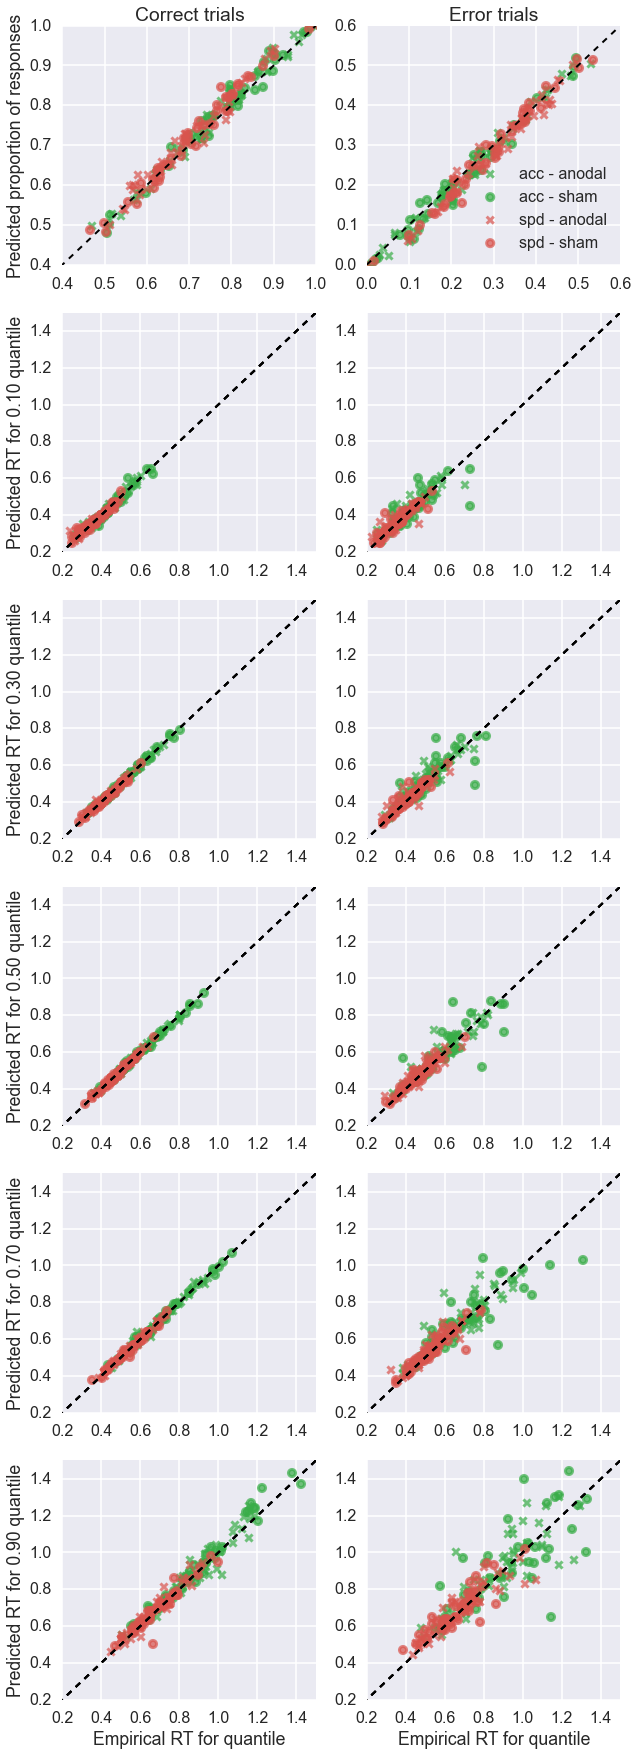

In [28]:
# ACCURACY PLOT
fig = plt.figure(figsize=(10,30))

color_dict = {'acc':sns.xkcd_rgb["medium green"],
              'spd':sns.xkcd_rgb["pale red"]}

tdcs_dict = {'sham':'o',
             'anodal':'x'}


## CORRECT TRIALS
plt.subplot(6, 2, 1)
for (acc_spd, tdcs), d in accuracy_data_prediction.groupby(['acc_spd', 'tdcs']):
    print acc_spd
    plt.scatter(d.accuracy_data, d.accuracy_predicted,
                s=50,
                color=color_dict[acc_spd],
                marker=tdcs_dict[tdcs],
                label='%s - %s' % (acc_spd, tdcs),
                linewidths=(3,),
                alpha=0.7)

    
plt.xlim(0.4, 1.0)
plt.ylim(0.4, 1.0)
plt.plot([0, 1], [0, 1], c='k', lw=2, ls='--')
#plt.xlabel('Data')
plt.ylabel('Predicted proportion of responses')
plt.title('Correct trials')

## INCORRECT TRIALS
plt.subplot(6, 2, 2)
for (acc_spd, tdcs), d in accuracy_data_prediction.groupby(['acc_spd', 'tdcs']):
    print acc_spd
    plt.scatter(1-d.accuracy_data, 1-d.accuracy_predicted,
                s=50,
                color=color_dict[acc_spd],
                marker=tdcs_dict[tdcs],
                label='%s - %s' % (acc_spd, tdcs),
                linewidths=(3,),
                alpha=0.7)

    
plt.xlim(0.0, 0.6)
plt.ylim(0.0, 0.6)
plt.plot([0, 1.05], [0, 1.05], c='k', lw=2, ls='--')
plt.legend(loc='lower right')
#plt.xlabel('Proportion of responses')
#plt.ylabel('Prediction DDM')
plt.title('Error trials')

for i, ((percentile, correct), d) in enumerate(data_predicted.groupby(['percentile', 'correct'])):
    plt.subplot(6, 2, 3 + i)
    #plt.title('%s percentile, %s trials' % (percentile, correct))
    for (acc_spd, tdcs), d2 in d.groupby(['acc_spd', 'tdcs']):
        
    
        plt.scatter(d2.value_data, d2.value_predicted,
            s=50,
            color=color_dict[acc_spd],
            marker=tdcs_dict[tdcs],
            label='%s - %s' % (acc_spd, tdcs),
            linewidths=(3,),
            alpha=0.7)
        
        if i % 2 == 0:
            plt.ylabel('Predicted RT for %.2f quantile' % (percentile / 100.))

        plt.plot([0, 1.5], [0, 1.5], c='k', lw=2, ls='--')
        plt.xlim(0.2, 1.5)
        plt.ylim(0.2, 1.5)
        
        if percentile == 90:
            plt.xlabel('Empirical RT for quantile')
        
    
plt.savefig('figure3.svg', transparent=True)
plt.savefig('figure3.png', dpi=300)
plt.savefig('figure3.tif', dpi=100)